In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import os

In [2]:
def load_quote_data(symbol, date):
    """
    Load a pickled DataFrame for the given symbol on the given date.
    
    - symbol: e.g. "XAU/USD"
    - date:   a Pandas Timestamp, datetime.date, or YYYY-MM-DD string
    
    File path structure assumed: Data/<symbol_no_slash>_<YYYY-MM-DD>.pkl
    Example: "Data/XAUUSD_2025-01-08.pkl"
    
    Returns:
        Pandas DataFrame if file exists, otherwise None.
    """
    # 1. Ensure date is a Timestamp
    if not isinstance(date, pd.Timestamp):
        date = pd.Timestamp(date)
    
    # 2. Convert symbol to a file-friendly format (remove slash)
    symbol_filename = symbol.replace('/', '')
    # 3. Build the date string
    date_str = date.strftime("%Y-%m-%d")
    # 4. Build the file path
    filepath = f"Data/{symbol_filename}_{date_str}.pkl"
    
    # 5. Load if it exists
    if os.path.exists(filepath):
        df = pd.read_pickle(filepath)
        return df
    else:
        print(f"File not found: {filepath}")
        return None


In [3]:
date = "2025-01-08"
symbol = "XAU/USD"
df_loaded = load_quote_data(symbol, date)
if df_loaded is not None:
    print(f"Loaded DataFrame with {len(df_loaded)} rows.")

Loaded DataFrame with 15546432 rows.


In [4]:
df_loaded['MakerId'].unique()


array(['Britannia'], dtype=object)

In [5]:
depth_dfs = {}  # Dictionary to store dataframes for each depth

for depth in range(7):  # Depth ranges from 0 to 6
    depth_dfs[f'sell_df_depth{depth}'] = df_loaded[(df_loaded["Side"] == 0) & (df_loaded["Depth"] == depth)].copy()
    depth_dfs[f'sell_df_depth{depth}'] = depth_dfs[f'sell_df_depth{depth}'].rename(columns={"Price": f"Sell_Price_Depth{depth}", "Size":  f"Sell_Size_Depth{depth}"})
    depth_dfs[f'sell_df_depth{depth}'] = depth_dfs[f'sell_df_depth{depth}'][["CoreSymbol", "TimeRecorded", f"Sell_Price_Depth{depth}", f"Sell_Size_Depth{depth}"]]


    depth_dfs[f'buy_df_depth{depth}'] = df_loaded[(df_loaded["Side"] == 1) & (df_loaded["Depth"] == depth)].copy()
    depth_dfs[f'buy_df_depth{depth}'] = depth_dfs[f'buy_df_depth{depth}'].rename(columns={"Price": f"Depth{depth}_Buy_Price", "Size":  f"Depth{depth}_Buy_Size"})
    depth_dfs[f'buy_df_depth{depth}'] = depth_dfs[f'buy_df_depth{depth}'][["CoreSymbol", "TimeRecorded", f"Depth{depth}_Buy_Price", f"Depth{depth}_Buy_Size"]]



# Initialize the merged dataframe with the first depth's dataframes
merged_df = depth_dfs['sell_df_depth0']
# Iterate through the remaining depths and merge them
for depth in range(1, 7):
    merged_df = merged_df.merge(depth_dfs[f'sell_df_depth{depth}'], on=["CoreSymbol", "TimeRecorded"], how="outer")

for depth in range(0, 7):
    merged_df = merged_df.merge(depth_dfs[f'buy_df_depth{depth}'], on=["CoreSymbol", "TimeRecorded"], how="outer")







In [6]:
trade_vol = 500

In [7]:
merged_df.columns

Index(['CoreSymbol', 'TimeRecorded', 'Sell_Price_Depth0', 'Sell_Size_Depth0',
       'Sell_Price_Depth1', 'Sell_Size_Depth1', 'Sell_Price_Depth2',
       'Sell_Size_Depth2', 'Sell_Price_Depth3', 'Sell_Size_Depth3',
       'Sell_Price_Depth4', 'Sell_Size_Depth4', 'Sell_Price_Depth5',
       'Sell_Size_Depth5', 'Sell_Price_Depth6', 'Sell_Size_Depth6',
       'Depth0_Buy_Price', 'Depth0_Buy_Size', 'Depth1_Buy_Price',
       'Depth1_Buy_Size', 'Depth2_Buy_Price', 'Depth2_Buy_Size',
       'Depth3_Buy_Price', 'Depth3_Buy_Size', 'Depth4_Buy_Price',
       'Depth4_Buy_Size', 'Depth5_Buy_Price', 'Depth5_Buy_Size',
       'Depth6_Buy_Price', 'Depth6_Buy_Size'],
      dtype='object')

In [8]:
def calculate_price_difference_per_row(row, trade_vol):
    import numpy as np

    # Initialize variables for buy and sell computations
    total_buy_vol = 0.0
    total_sell_vol = 0.0
    weighted_buy_price = 0.0
    weighted_sell_price = 0.0

    # Calculate total available volumes for buy and sell
    max_buy_vol = np.sum([row[f"Depth{depth}_Buy_Size"] for depth in range(7)])
    max_sell_vol = np.sum([row[f"Sell_Size_Depth{depth}"] for depth in range(7)])

    # Cap trade volume at the maximum available volume
    capped_trade_vol = min(trade_vol, max_buy_vol, max_sell_vol)

    # Simulate buy process
    remaining_vol = capped_trade_vol
    for depth in range(7):
        buy_price = row[f"Depth{depth}_Buy_Price"]
        buy_size = row[f"Depth{depth}_Buy_Size"]

        # Accumulate volume and weighted price
        if remaining_vol <= 0:
            break
        buyable_vol = min(buy_size, remaining_vol)
        weighted_buy_price += np.multiply(buyable_vol, buy_price)
        total_buy_vol += buyable_vol
        remaining_vol -= buyable_vol

    # Simulate sell process
    remaining_vol = capped_trade_vol
    for depth in range(7):
        sell_price = row[f"Sell_Price_Depth{depth}"]
        sell_size = row[f"Sell_Size_Depth{depth}"]

        # Accumulate volume and weighted price
        if remaining_vol <= 0:
            break
        sellable_vol = min(sell_size, remaining_vol)
        weighted_sell_price += np.multiply(sellable_vol, sell_price)
        total_sell_vol += sellable_vol
        remaining_vol -= sellable_vol

    # Calculate average prices with protection against division by zero
    avg_buy_price = np.divide(weighted_buy_price, total_buy_vol) if total_buy_vol > 0 else np.nan
    avg_sell_price = np.divide(weighted_sell_price, total_sell_vol) if total_sell_vol > 0 else np.nan

    # Calculate price difference
    price_difference = avg_buy_price - avg_sell_price if not np.isnan(avg_buy_price) and not np.isnan(avg_sell_price) else np.nan

    return price_difference



In [9]:
# Apply the function to every row in merged_df
trade_vol = 500
merged_df["Point_Diff"] = merged_df.apply(
    lambda row: calculate_price_difference_per_row(row, trade_vol), axis=1
)

In [10]:
merged_df

,CoreSymbol,TimeRecorded,Sell_Price_Depth0,Sell_Size_Depth0,Sell_Price_Depth1,Sell_Size_Depth1,Sell_Price_Depth2,Sell_Size_Depth2,Sell_Price_Depth3,Sell_Size_Depth3,...,Depth2_Buy_Size,Depth3_Buy_Price,Depth3_Buy_Size,Depth4_Buy_Price,Depth4_Buy_Size,Depth5_Buy_Price,Depth5_Buy_Size,Depth6_Buy_Price,Depth6_Buy_Size,Point_Diff
0,XAU/USD,2025-01-08 00:00:00.027831,2649.73,100.0,2649.72,300.0,2649.69,500.0,2649.69,1000.0,...,300.0,2650.01,500.0,2650.02,100.0,2650.04,1000.0,2650.05,300.0,0.260
1,XAU/USD,2025-01-08 00:00:00.027831,2649.73,100.0,2649.72,300.0,2649.69,500.0,2649.69,1000.0,...,300.0,2650.01,500.0,2650.02,100.0,2650.04,1000.0,2650.05,300.0,0.260
2,XAU/USD,2025-01-08 00:00:00.027831,2649.73,100.0,2649.72,300.0,2649.69,500.0,2649.69,1000.0,...,300.0,2650.01,500.0,2650.02,100.0,2650.04,1000.0,2650.05,300.0,0.260
3,XAU/USD,2025-01-08 00:00:00.027831,2649.73,100.0,2649.72,300.0,2649.69,500.0,2649.69,1000.0,...,300.0,2650.01,500.0,2650.02,100.0,2650.04,1000.0,2650.05,300.0,0.260
4,XAU/USD,2025-01-08 00:00:00.117803,2649.73,100.0,2649.72,300.0,2649.70,100.0,2649.69,500.0,...,300.0,2650.01,500.0,2650.02,100.0,2650.04,1000.0,2650.05,300.0,0.258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3886671,XAU/USD,2025-01-08 23:59:59.082723,2662.60,100.0,2662.59,100.0,2662.57,300.0,2662.56,500.0,...,300.0,2662.84,100.0,2662.85,1000.0,2662.85,100.0,2662.87,2000.0,0.250
3886672,XAU/USD,2025-01-08 23:59:59.255444,2662.60,100.0,2662.59,100.0,2662.57,300.0,2662.56,500.0,...,300.0,2662.84,100.0,2662.85,1000.0,2662.85,100.0,2662.87,2000.0,0.250
3886673,XAU/USD,2025-01-08 23:59:59.255444,2662.60,100.0,2662.59,100.0,2662.57,300.0,2662.56,500.0,...,300.0,2662.84,100.0,2662.85,1000.0,2662.85,100.0,2662.87,2000.0,0.250
3886674,XAU/USD,2025-01-08 23:59:59.255444,2662.60,100.0,2662.59,100.0,2662.57,300.0,2662.56,500.0,...,300.0,2662.84,100.0,2662.85,1000.0,2662.85,100.0,2662.87,2000.0,0.250


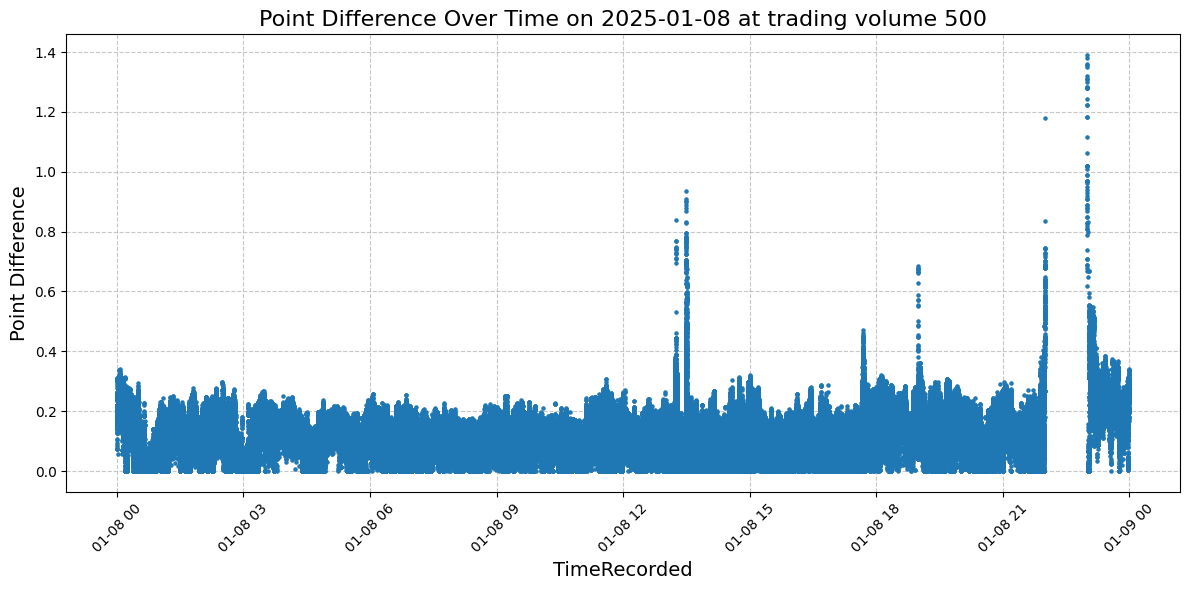

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(
    merged_df["TimeRecorded"], 
    merged_df["Point_Diff"], 
    marker="o",         # shape of the point (circle)
    linestyle="none",   # no connecting line
    markersize=2,       # size of the dots
    alpha=0.5
)
plt.title(f"Point Difference Over Time on {date} at trading volume {trade_vol}", fontsize=16)
plt.xlabel("TimeRecorded", fontsize=14)
plt.ylabel("Point Difference", fontsize=14)
plt.xticks(rotation=45)
plt.grid(linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

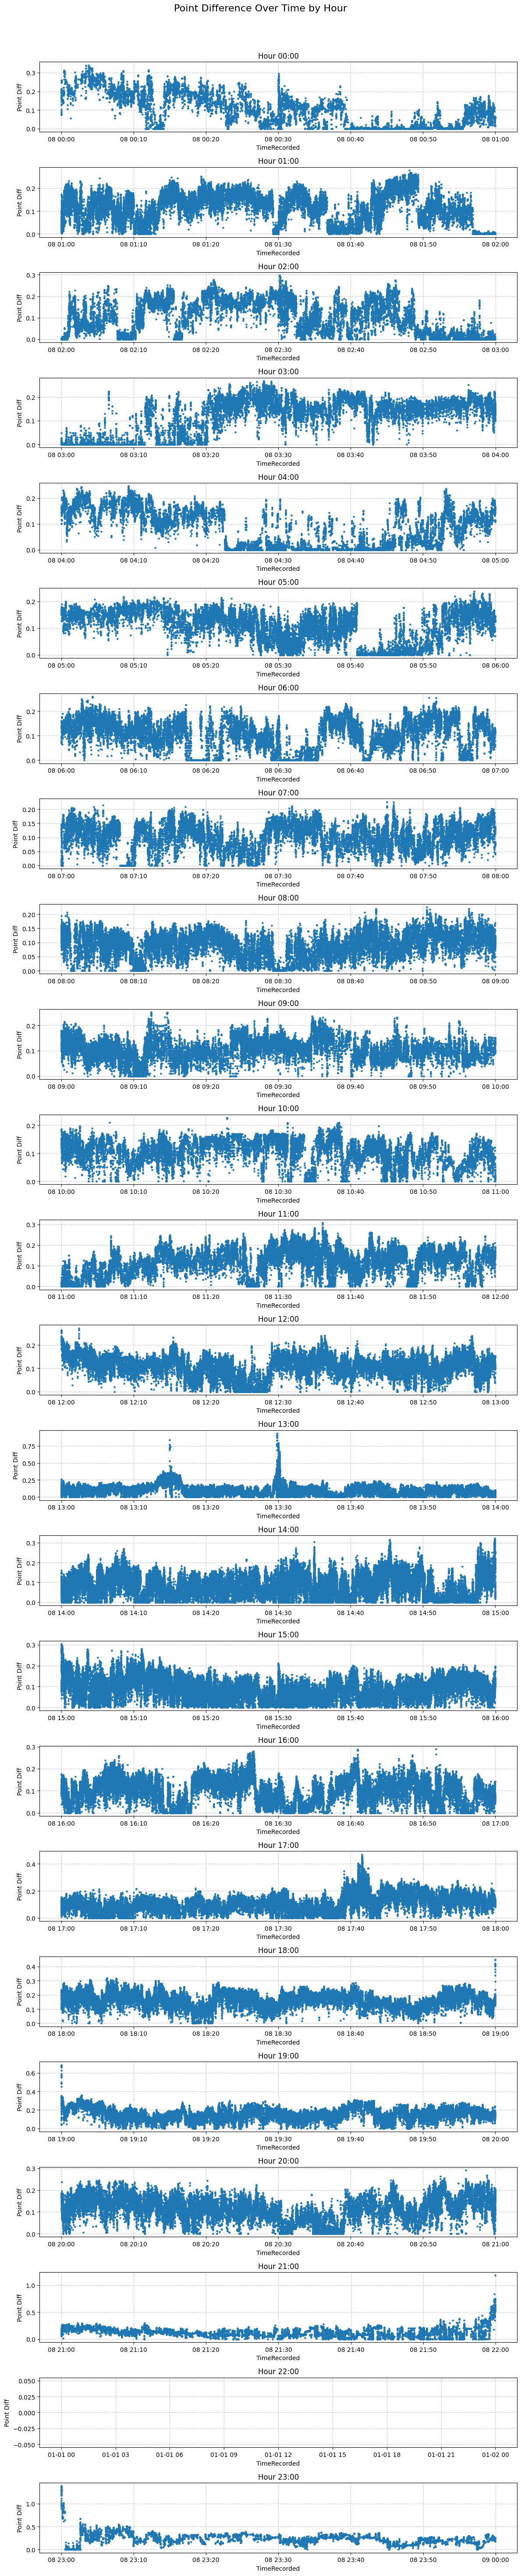

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Ensure TimeRecorded is datetime (if not already)
# merged_df['TimeRecorded'] = pd.to_datetime(merged_df['TimeRecorded'])

# 2) Extract the hour component
merged_df['Hour'] = merged_df['TimeRecorded'].dt.hour

# 3) Pre-calculate global y-limits so all subplots share them
y_min = merged_df["Point_Diff"].min()
y_max = merged_df["Point_Diff"].max()

# 4) Create a figure with 24 subplots (one per hour)
fig, axes = plt.subplots(nrows=24, ncols=1, figsize=(12, 60), sharex=False, sharey=False)
fig.suptitle("Point Difference Over Time by Hour", fontsize=16)

for hour in range(24):
    ax = axes[hour]
    # Subset data for this specific hour
    hour_df = merged_df[merged_df['Hour'] == hour]

    # Plot dots only (no line)
    ax.plot(
        hour_df["TimeRecorded"], 
        hour_df["Point_Diff"], 
        marker="o", 
        linestyle="none",   # <-- This makes it only dots
        markersize=2, 
        alpha=0.5
    )
    
    # Keep the same y-limits across all subplots
    # ax.set_ylim([y_min, y_max])
    
    # Labeling
    ax.set_title(f"Hour {hour:02d}:00", fontsize=12)
    ax.set_xlabel("TimeRecorded", fontsize=10)
    ax.set_ylabel("Point Diff", fontsize=10)
    ax.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.97])  # leaves space at the top for suptitle
plt.show()

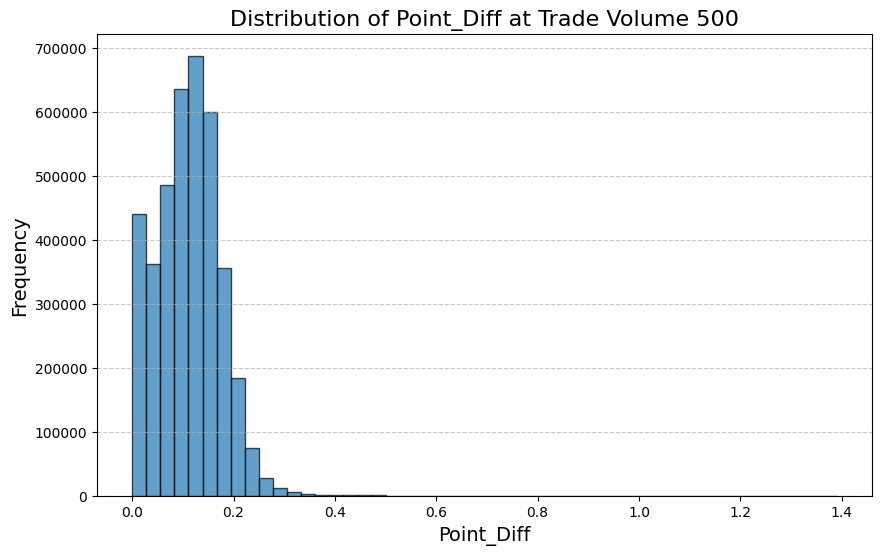

In [21]:
plt.figure(figsize=(10, 6))
plt.hist(merged_df["Point_Diff"], bins=50, edgecolor="k", alpha=0.7)
plt.title(f"Distribution of Point_Diff at Trade Volume {trade_vol}", fontsize=16)
plt.xlabel("Point_Diff", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


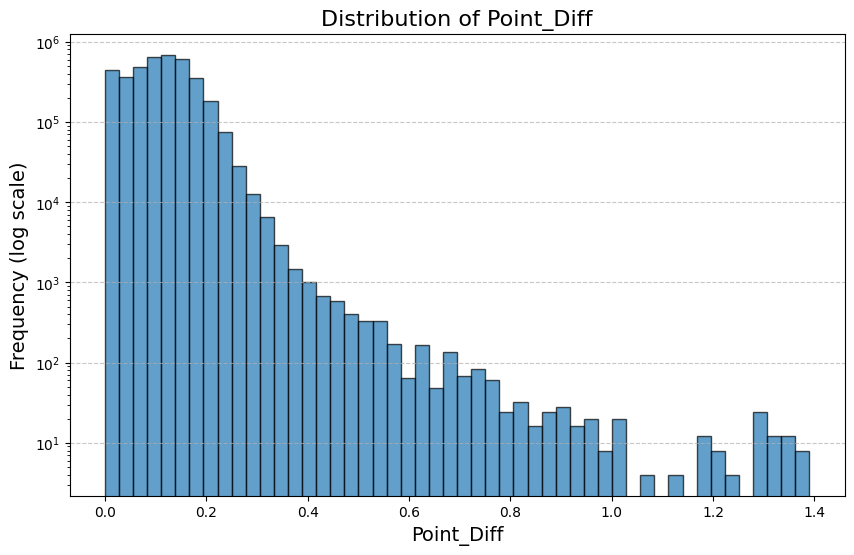

In [14]:
plt.figure(figsize=(10, 6))
plt.hist(
    merged_df["Point_Diff"], 
    bins=50, 
    edgecolor="k", 
    alpha=0.7, 
    log=True  # <-- This enables log scale on the y-axis
)
plt.title("Distribution of Point_Diff", fontsize=16)
plt.xlabel("Point_Diff", fontsize=14)
plt.ylabel("Frequency (log scale)", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

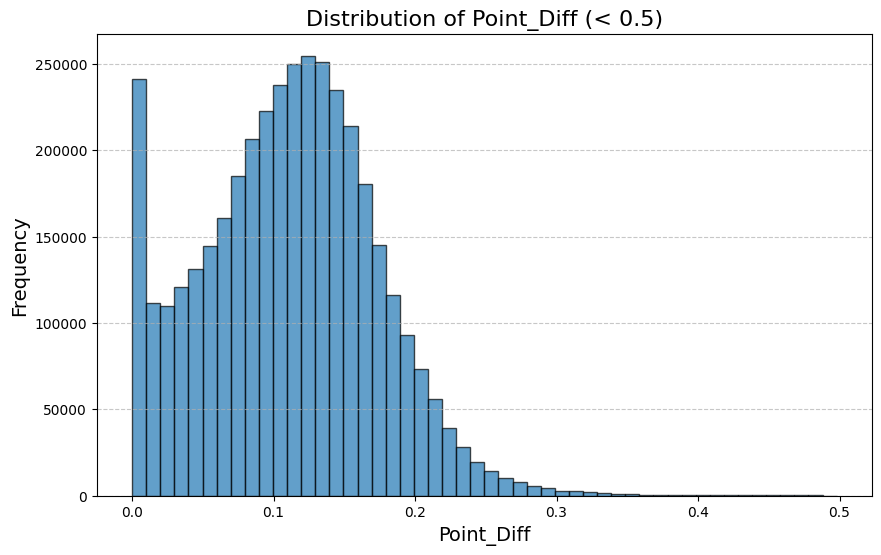

In [15]:


# Filter your data
filtered_df = merged_df[merged_df["Point_Diff"] < 0.5]

# Plot the distribution of `Point_Diff` under 0.5
plt.figure(figsize=(10, 6))
plt.hist(filtered_df["Point_Diff"], bins=50, edgecolor="k", alpha=0.7)
plt.title("Distribution of Point_Diff (< 0.5)", fontsize=16)
plt.xlabel("Point_Diff", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

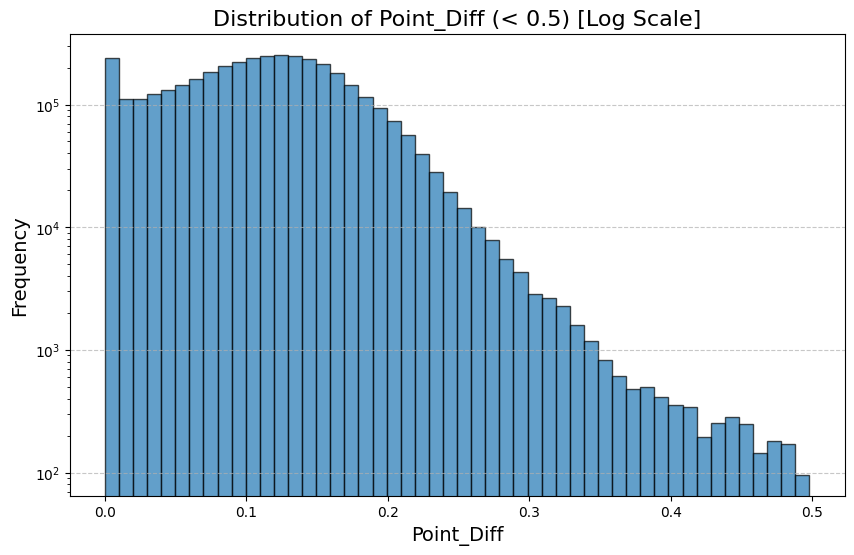

In [16]:
# Filter your data
filtered_df = merged_df[merged_df["Point_Diff"] < 0.5]

# Plot the distribution of `Point_Diff` under 0.5 (log scale on y-axis)
plt.figure(figsize=(10, 6))
plt.hist(
    filtered_df["Point_Diff"], 
    bins=50, 
    edgecolor="k", 
    alpha=0.7, 
    log=True  # <-- This makes the y-axis logarithmic
)
plt.title("Distribution of Point_Diff (< 0.5) [Log Scale]", fontsize=16)
plt.xlabel("Point_Diff", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

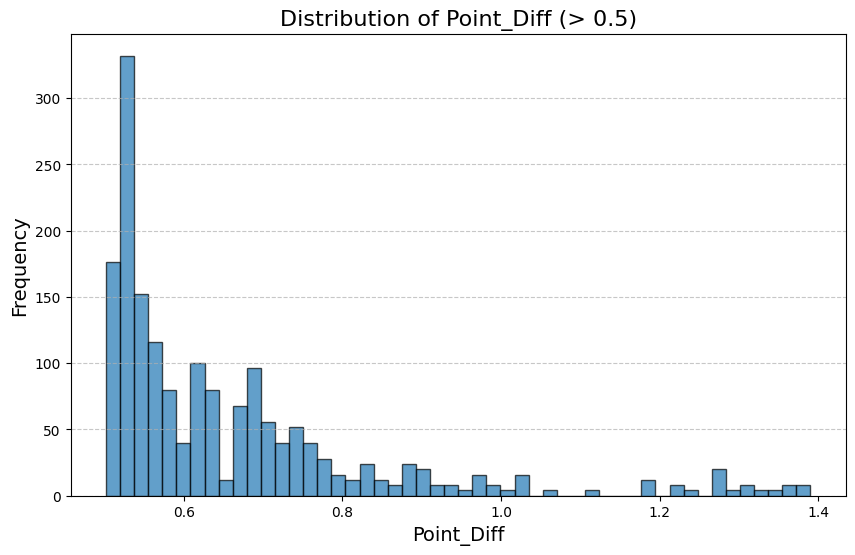

In [17]:
filtered_df = merged_df[merged_df["Point_Diff"] > 0.5]

# Plot the distribution of Point_Diff (> 0.5)
plt.figure(figsize=(10, 6))
plt.hist(
    filtered_df["Point_Diff"], 
    bins=50, 
    edgecolor="k", 
    alpha=0.7
)
plt.title("Distribution of Point_Diff (> 0.5)", fontsize=16)
plt.xlabel("Point_Diff", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [18]:

# 1. Quick overview (count, mean, std, min, quartiles, max, etc.)
print("=== Describe (default percentiles) ===")
print(merged_df['Point_Diff'].describe())

# 2. Custom percentiles (e.g., 5th, 25th, 50th, 75th, 95th)
print("\n=== Describe (custom percentiles) ===")
print(merged_df['Point_Diff'].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))

# 3. Specific summary statistics
mean_val = merged_df['Point_Diff'].mean()
median_val = merged_df['Point_Diff'].median()
std_val = merged_df['Point_Diff'].std()
var_val = merged_df['Point_Diff'].var()
min_val = merged_df['Point_Diff'].min()
max_val = merged_df['Point_Diff'].max()
skew_val = merged_df['Point_Diff'].skew()
kurt_val = merged_df['Point_Diff'].kurt()

print("\n=== Specific Statistics ===")
print(f"Mean: {mean_val}")
print(f"Median: {median_val}")
print(f"Standard Deviation: {std_val}")
print(f"Variance: {var_val}")
print(f"Min: {min_val}")
print(f"Max: {max_val}")
print(f"Skewness: {skew_val}")
print(f"Kurtosis: {kurt_val}")

# # 4. If you need specific percentiles programmatically, you can also use numpy:
# perc_10, perc_90 = np.percentile(merged_df['Point_Diff'], [10, 90])
# print("\n=== Additional Percentiles ===")
# print(f"10th Percentile: {perc_10}")
# print(f"90th Percentile: {perc_90}")

=== Describe (default percentiles) ===
count    3.886640e+06
mean     1.105335e-01
std      6.321356e-02
min     -4.547474e-13
25%      6.600000e-02
50%      1.120000e-01
75%      1.520000e-01
max      1.390000e+00
Name: Point_Diff, dtype: float64

=== Describe (custom percentiles) ===
count    3.886640e+06
mean     1.105335e-01
std      6.321356e-02
min     -4.547474e-13
5%       6.000000e-03
25%      6.600000e-02
50%      1.120000e-01
75%      1.520000e-01
95%      2.100000e-01
max      1.390000e+00
Name: Point_Diff, dtype: float64

=== Specific Statistics ===
Mean: 0.11053351505670526
Median: 0.11200000000008004
Standard Deviation: 0.06321356247560445
Variance: 0.003995954480857147
Min: -4.547473508864641e-13
Max: 1.3899999999998727
Skewness: 0.6701188328557534
Kurtosis: 5.410943335102587


Lower Bound: -0.06299999999873762
Upper Bound: 0.2809999999985848
Number of Outliers: 25880


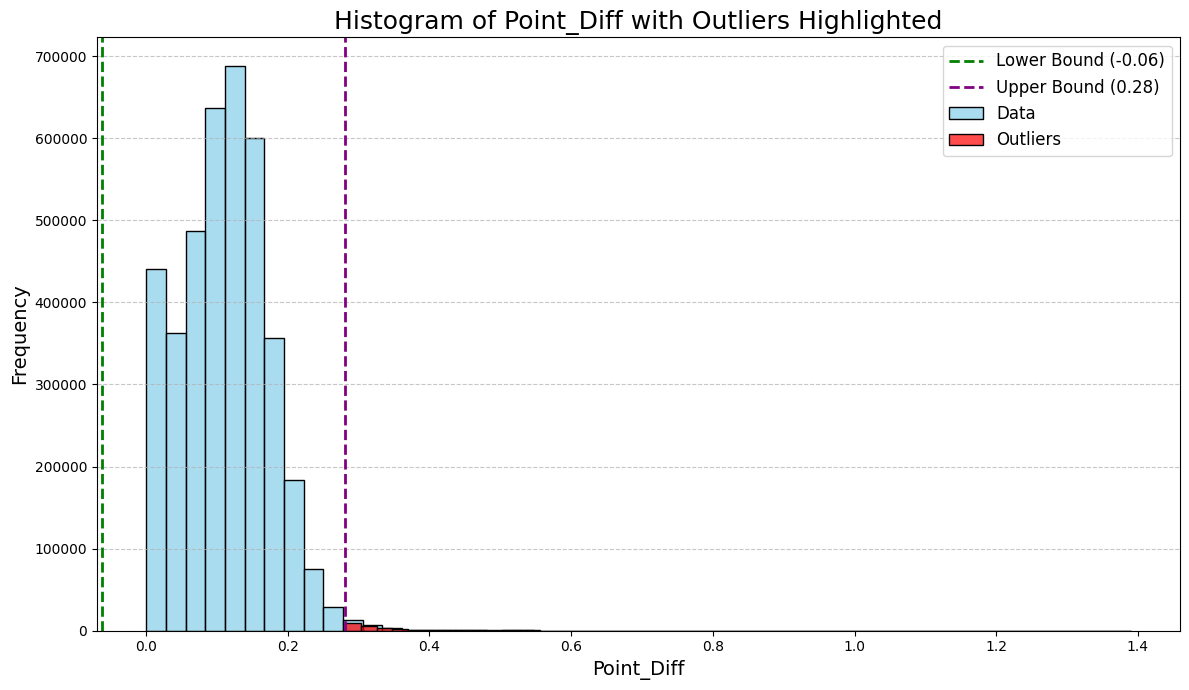

In [19]:

# 1. Calculate Q1, Q3, and IQR
Q1 = merged_df["Point_Diff"].quantile(0.25)
Q3 = merged_df["Point_Diff"].quantile(0.75)
IQR = Q3 - Q1

# 2. Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")

# 3. Identify outliers
outliers = merged_df[(merged_df["Point_Diff"] < lower_bound) | (merged_df["Point_Diff"] > upper_bound)]
print(f"Number of Outliers: {len(outliers)}")

# 4. Plotting
plt.figure(figsize=(12, 7))

# Plot histogram for all data
sns.histplot(
    merged_df["Point_Diff"], 
    bins=50, 
    color='skyblue', 
    edgecolor='black', 
    label='Data', 
    alpha=0.7
)

# Overlay histogram for outliers
if not outliers.empty:
    sns.histplot(
        outliers["Point_Diff"], 
        bins=50, 
        color='red', 
        edgecolor='black', 
        label='Outliers', 
        alpha=0.7
    )

# Plot vertical lines for bounds
plt.axvline(lower_bound, color='green', linestyle='--', linewidth=2, label=f'Lower Bound ({lower_bound:.2f})')
plt.axvline(upper_bound, color='purple', linestyle='--', linewidth=2, label=f'Upper Bound ({upper_bound:.2f})')

# Title and labels
plt.title("Histogram of Point_Diff with Outliers Highlighted", fontsize=18)
plt.xlabel("Point_Diff", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Legend
plt.legend(fontsize=12)

# Grid
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()